In [1]:
%pip install gym==0.23.1
%pip install gym_super_mario_bros==7.3.0 nes_py
%pip install torch
%pip install numpy
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Importing necessary libraries and sepcifying DQN model
# Libs imports

import gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from nes_py.wrappers import JoypadSpace
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import cv2

# DQN model specification
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Using ReLU functions on layers specifying input layers, middle layers and output layer

In [2]:
print(gym.__version__)

0.23.1


In [3]:
# Define Image processing and frame stackign functions

# Image preprocessing function (grayscale, resize, normalize)
def preprocess_observation(obs):
    obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    obs = cv2.resize(obs, (84, 84))  # Resize to 84x84
    obs = obs / 255.0  # Normalize pixel values
    return obs

# Frame stacking function
def stack_frames(stacked_frames, frame, is_new_episode):
    if is_new_episode:
        # Reset the frame stack for a new episode
        stacked_frames = deque([frame] * 4, maxlen=4)
    else:
        # Append new frames
        stacked_frames.append(frame)
    # Return the stacked frames as a numpy array
    stacked_state = np.stack(stacked_frames, axis=0)
    return stacked_state, stacked_frames

# The preprocess_observation function converts images to grayscale
# resizing them and normalizes the pixel values
# stack_frames function manages a queue of frames and returns the stacked state for temporal information

In [4]:
# Modify pre-programmed action function to include a long jump feature
def pre_programmed_action(state, hold_jump_steps):
    single_frame = state[0]  # Use the first frame from the stack

    # Apply Gaussian blur to reduce noise
    blurred_frame = cv2.GaussianBlur(single_frame, (5, 5), 0)

    # Apply adaptive thresholding to binarize the image
    thresh_frame = cv2.adaptiveThreshold(np.uint8(blurred_frame * 255), 255, 
                                         cv2.ADAPTIVE_THRESH_MEAN_C, 
                                         cv2.THRESH_BINARY_INV, 11, 2)

    # Detect contours
    contours, _ = cv2.findContours(thresh_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    obstacle_detected = False
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 50:  # Only consider contours with a significant area
            x, y, w, h = cv2.boundingRect(contour)
            if x > 60 and x < 100:  # Define Mario's forward area
                obstacle_detected = True
                print("obstacel detected")
                # Draw rectangle around the detected contour for debugging
                cv2.rectangle(thresh_frame, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
    # Display debugging image
    cv2.imshow("Detection", thresh_frame)
    cv2.waitKey(1)

    # If in the middle of holding the jump, continue
    if hold_jump_steps > 0:
        print("Regular jump holding")
        return 2, hold_jump_steps - 1  # Continue regular jump (right + A)

    # Decide Mario's action based on detected obstacles
    if obstacle_detected:
        print("Regular jump")
        return 2, hold_jump_steps - 1  # Initiate Regular jumps
    else:
        print("Moving Right")
        return 1, 0  # Move right (right)

# Epsilon-Greedy action selection function (includes pre-programmed behavior)
def select_action(state, epsilon, policy_net, output_dim, repeated_action_count, last_action, hold_jump_steps, use_pre_programmed=False):
    if use_pre_programmed:
        action, hold_jump_steps = pre_programmed_action(state, hold_jump_steps)  
        # Use pre-programmed action with long jump
    else:
        state_tensor = torch.tensor(state.flatten(), dtype=torch.float32).unsqueeze(0).to(device)
        if random.random() > epsilon:
            with torch.no_grad():
                q_values = policy_net(state_tensor)
                action = q_values.max(1)[1].item()
        else:
            action = random.choice(range(output_dim))
    
    # Check if the action has been repeated for more than 60 times
    if action == last_action:
        repeated_action_count += 1
    else:
        repeated_action_count = 0  # Reset the count if a new action is chosen

    # If the same action is repeated more than 60 times, trigger a long jump
    if repeated_action_count >= 60:
        jump_duration = random.randint(15, 25)
        print("Long Jump Triggered!")
        action, hold_jump_steps = 2, jump_duration  # Trigger a long jump (right + A for 15-25 frames)
        repeated_action_count = 0  # Reset after performing a long jump

    return action, repeated_action_count, action, hold_jump_steps  # Return the action, updated
    # count, and current action

# the pre_programmed_action function detects obstacles using image processing techniques
# and returns the appropriate action (jump or move right).
# the select_action function uses either the DQN model or the pre-programmed behavior based on the
# eplison value

In [5]:
# Q-learning update function
def compute_loss(policy_net, target_net, batch, gamma):
    states, actions, rewards, next_states, dones = batch

    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    q_values = policy_net(states)
    next_q_values = target_net(next_states)

    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_values.max(1)[0]

    expected_q_value = rewards + gamma * next_q_value * (1 - dones)
    
    loss = nn.MSELoss()(q_value, expected_q_value)
    return loss

# Set up GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute_loss function calculates the Q-learning loss by comparing the predicted
# Q values with the expected Q values
# GPU setup included to speed up computation(if its available)


In [8]:
# Initialize the environment and run the training loop

# Initialize the environment
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v3')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = gym.wrappers.TimeLimit(env, max_episode_steps=1000)

# Set hyperparameters
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.00025
batch_size = 32
target_update = 10
memory_capacity = 10000
input_dim = 84 * 84 * 4  # 84x84 grayscale images stacked 4 times
output_dim = env.action_space.n

# Initialize the DQN networks
policy_net = DQN(input_dim, output_dim).to(device)
target_net = DQN(input_dim, output_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Define the replay memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

memory = ReplayMemory(memory_capacity)

# Training loop
for episode in range(1):  # Example for 100 episodes
    # Save the trained model after the training loop
    torch.save(policy_net.state_dict(), "dqn_mario_with_preprogrammed_behavior.pth")
    print("Model saved as dqn_mario_with_preprogrammed_behavior.pth")

    
    stacked_frames = deque(maxlen=4)  # Reset frame stack
    state = env.reset()
    state = preprocess_observation(state)
    state, stacked_frames = stack_frames(stacked_frames, state, True)
    done = False
    total_reward = 0
    render_interval = 1

    step_count = 0
    repeated_action_count = 0  # Initialize repeated action count
    last_action = -1  # Initialize last action
    hold_jump_steps = 0  # Initialize hold jump steps
    
    while not done:
        # Decide whether to use pre-programmed behavior based on epsilon
        use_pre_programmed = epsilon > 0.5

        # Select action, track repetitions, last action, and long jump hold
        action, repeated_action_count, last_action, hold_jump_steps = select_action(
            state, epsilon, policy_net, output_dim, repeated_action_count, last_action, hold_jump_steps, use_pre_programmed
        )

        next_state, reward, done, _ = env.step(action)
        next_state = preprocess_observation(next_state)
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
        total_reward += reward

        # Store experience in replay memory
        memory.push(state.flatten(), action, reward, next_state.flatten(), done)

        state = next_state

        # Perform batch training
        if len(memory) >= batch_size:
            batch = memory.sample(batch_size)
            batch = zip(*batch)
            loss = compute_loss(policy_net, target_net, batch, gamma)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if step_count % render_interval == 0:
            env.render()

        step_count += 1

        if done:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {epsilon}")
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())




# environment is initialized and training loop is running for set of num of episodes.
# for each episode actions are selected absed on eplison greedy strategy
# then experiences are sotred in the replay memory
# Then DQN is updated based on the stored experience


Model saved as dqn_mario_with_preprogrammed_behavior.pth
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right


C:\Users\shsj0\AppData\Local\Temp\ipykernel_2020\1735106354.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.tensor(states, dtype=torch.float32).to(device)


Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving R

c:\Users\shsj0\Desktop\Mario Testing\.venv\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving 

In [11]:
# Running the DQN model that is learned with initializing
# Load the trained model and evaluate
policy_net.load_state_dict(torch.load("run Kane 2 here"))
policy_net.eval()

# Evaluation metrics
rewards_per_episode = []
q_values_per_episode = []
action_distributions = []

obs = env.reset()
stacked_frames = deque(maxlen=4)  # Reset frame stack for evaluation
obs = preprocess_observation(obs)
obs, stacked_frames = stack_frames(stacked_frames, obs, True)

# Initialize repeated_action_count, last_action, and hold_jump_steps for evaluation
repeated_action_count = 0
last_action = -1  # Start with an invalid action
hold_jump_steps = 0  # Initialize hold_jump_steps for long jump feature
total_reward = 0  # Track rewards for this episode
actions_counter = np.zeros(output_dim)  # Track action distribution
q_values_episode = []  # Track Q-values

while True:
    # Pass the additional parameters to select_action, including hold_jump_steps
    action, repeated_action_count, last_action, hold_jump_steps = select_action(
        obs, epsilon=0.0, policy_net=policy_net, output_dim=output_dim, 
        repeated_action_count=repeated_action_count, last_action=last_action, 
        hold_jump_steps=hold_jump_steps, use_pre_programmed=False
    )

    # Count the chosen action for action distribution
    actions_counter[action] += 1

    # Track the Q-value for the chosen action
    with torch.no_grad():
        state_tensor = torch.tensor(obs.flatten(), dtype=torch.float32).unsqueeze(0).to(device)
        q_values = policy_net(state_tensor)
        q_value = q_values.max(1)[0].item()  # Max Q-value
        q_values_episode.append(q_value)

    next_obs, reward, done, _ = env.step(action)
    next_obs = preprocess_observation(next_obs)
    obs, stacked_frames = stack_frames(stacked_frames, next_obs, False)

    total_reward += reward  # Accumulate reward for this episode

    env.render()

    if done:
        # Append episode metrics
        rewards_per_episode.append(total_reward)
        action_distributions.append(actions_counter)
        q_values_per_episode.append(np.mean(q_values_episode))  # Average Q-value for the episode

        # Reset environment for the next episode
        obs = env.reset()
        obs = preprocess_observation(obs)
        obs, stacked_frames = stack_frames(stacked_frames, obs, True)
        
        # Reset repeated_action_count, last_action, hold_jump_steps, and other metrics
        repeated_action_count = 0
        last_action = -1
        hold_jump_steps = 0
        total_reward = 0
        actions_counter = np.zeros(output_dim)
        q_values_episode = []


C:\Users\shsj0\AppData\Local\Temp\ipykernel_2020\1752368704.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load("dqn_mario_with_improve

Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!
Long Jump Triggered!


KeyboardInterrupt: 

: 

In [ ]:
# For statistical analysis only
import matplotlib.pyplot as plt
import numpy as np

# Plotting rewards over time
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards per Episode')
plt.show()

# Plotting average Q-values over time
plt.figure(figsize=(10, 5))
plt.plot(q_values_per_episode)
plt.xlabel('Episode')
plt.ylabel('Average Q-Value')
plt.title('Average Q-Value per Episode')
plt.show()

# Plotting action distribution for the last episode
plt.figure(figsize=(10, 5))
plt.bar(range(output_dim), action_distributions[-1])
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Action Distribution in Last Episode')
plt.show()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
# Initialize the environment
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v3')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = gym.wrappers.TimeLimit(env, max_episode_steps=1000)

# Set hyperparameters
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.00025
batch_size = 32
target_update = 10
memory_capacity = 10000
input_dim = 84 * 84 * 4  # 84x84 grayscale images stacked 4 times
output_dim = env.action_space.n

# Initialize the DQN networks
policy_net = DQN(input_dim, output_dim).to(device)
target_net = DQN(input_dim, output_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Define the replay memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

memory = ReplayMemory(memory_capacity)

# Initialize lists to store metrics for statistical analysis
rewards_per_episode = []
epsilon_per_episode = []
loss_per_episode = []
action_distribution = np.zeros(output_dim)  # Track action counts

# Training loop
for episode in range(30):  # Training for 30 episodes
    stacked_frames = deque(maxlen=4)  # Reset frame stack
    state = env.reset()
    state = preprocess_observation(state)
    state, stacked_frames = stack_frames(stacked_frames, state, True)
    done = False
    total_reward = 0
    render_interval = 1

    step_count = 0
    repeated_action_count = 0  # Initialize repeated action count
    last_action = -1  # Initialize last action
    hold_jump_steps = 0  # Initialize hold jump steps
    episode_loss = 0  # Track total loss for the episode
    action_count = np.zeros(output_dim)  # Track action selection distribution

    while not done:
        # Decide whether to use pre-programmed behavior based on epsilon
        use_pre_programmed = epsilon > 0.5

        # Select action, track repetitions, last action, and long jump hold
        action, repeated_action_count, last_action, hold_jump_steps = select_action(
            state, epsilon, policy_net, output_dim, repeated_action_count, last_action, hold_jump_steps, use_pre_programmed
        )

        # Track action distribution
        action_count[action] += 1

        next_state, reward, done, _ = env.step(action)
        next_state = preprocess_observation(next_state)
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
        total_reward += reward

        # Store experience in replay memory
        memory.push(state.flatten(), action, reward, next_state.flatten(), done)

        state = next_state

        # Perform batch training
        if len(memory) >= batch_size:
            batch = memory.sample(batch_size)
            batch = zip(*batch)
            loss = compute_loss(policy_net, target_net, batch, gamma)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            episode_loss += loss.item()  # Accumulate loss for the episode

        if step_count % render_interval == 0:
            env.render()

        step_count += 1

        if done:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {epsilon}")
            break

    # Save metrics after each episode
    rewards_per_episode.append(total_reward)
    epsilon_per_episode.append(epsilon)
    loss_per_episode.append(episode_loss / step_count)  # Average loss for the episode
    action_distribution += action_count

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

# Save the trained model after the training loop
torch.save(policy_net.state_dict(), "dqn_mario_with_preprogrammed_behavior.pth")
print("Model saved as dqn_mario_with_preprogrammed_behavior.pth")


Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right


C:\Users\shsj0\AppData\Local\Temp\ipykernel_25556\1735106354.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.tensor(states, dtype=torch.float32).to(device)


Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving R

c:\Users\shsj0\Desktop\Mario Testing\.venv\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
obstacel detected
Regular jump
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving Right
Moving 

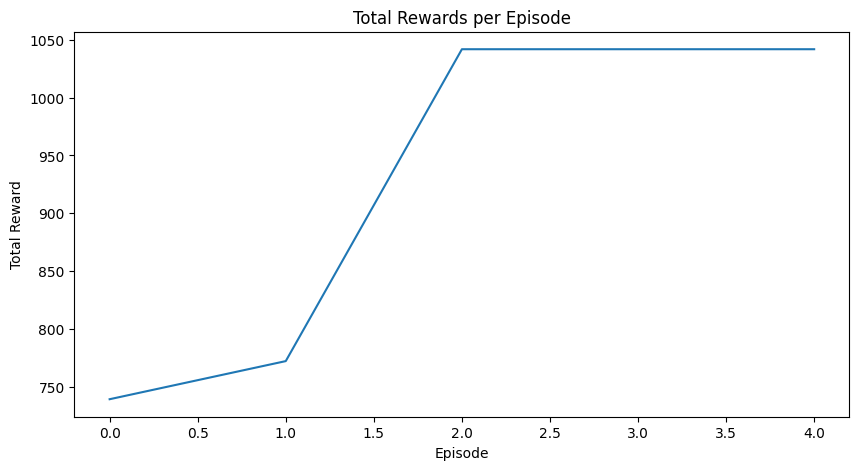

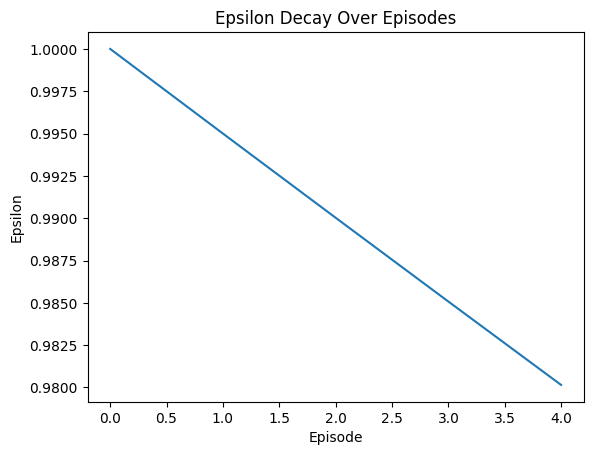

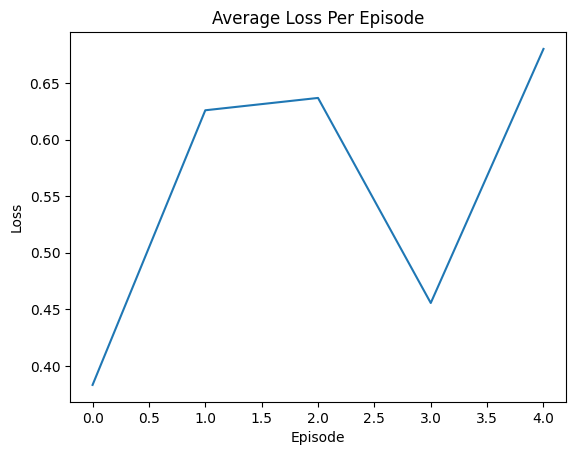

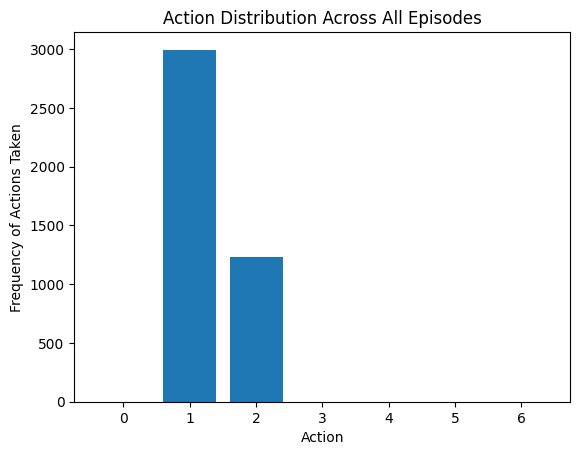

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting rewards over time
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards per Episode')
plt.show()
plt.plot(epsilon_per_episode)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()
plt.plot(loss_per_episode)
plt.title('Average Loss Per Episode')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.show()
plt.bar(range(output_dim), action_distribution)
plt.title('Action Distribution Across All Episodes')
plt.xlabel('Action')
plt.ylabel('Frequency of Actions Taken')
plt.show()